In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import hashlib
import numpy as np

In [2]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input

mixed_precision.set_global_policy('mixed_float16')

2025-07-06 06:41:39.605505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751784099.789070      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751784099.844628      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# EDA AND PREPROCESSING

In [3]:
base_dir = "/kaggle/input/cassava-leaf-disease-classification"

In [4]:
with open(os.path.join(base_dir, "label_num_to_disease_map.json")) as file:
    map_classes = json.loads(file.read())
    map_classes = {int(k) : v for k, v in map_classes.items()}
    
print(json.dumps(map_classes, indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [5]:
train_dir = "/kaggle/input/cassava-leaf-disease-classification/train_images"
test_dir = "/kaggle/input/cassava-leaf-disease-classification/test_images"

In [6]:
len(os.listdir(train_dir)) , len(os.listdir(test_dir))



(21397, 1)

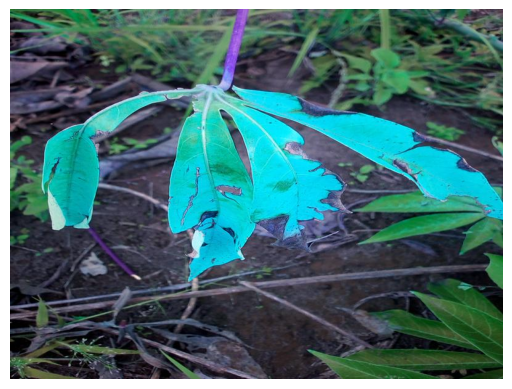

In [7]:
leaf_img = "/kaggle/input/cassava-leaf-disease-classification/train_images/1001723730.jpg"
img = cv2.imread(leaf_img)
img
plt.imshow(img)

plt.axis('off')
plt.show()

In [8]:
img.shape
#RGB IMAGE

(600, 800, 3)

In [9]:
df_train = pd.read_csv(os.path.join(base_dir, "train.csv"))

df_train["class_name"] = df_train["label"].map(map_classes)

df_train

image_id  label                           class_name
0      1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1      1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2       100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3      1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4      1000812911.jpg      3         Cassava Mosaic Disease (CMD)
...               ...    ...                                  ...
21392   999068805.jpg      3         Cassava Mosaic Disease (CMD)
21393   999329392.jpg      3         Cassava Mosaic Disease (CMD)
21394   999474432.jpg      1  Cassava Brown Streak Disease (CBSD)
21395   999616605.jpg      4                              Healthy
21396   999998473.jpg      4                              Healthy

[21397 rows x 3 columns]

**21397 rows × 3 columns**# 



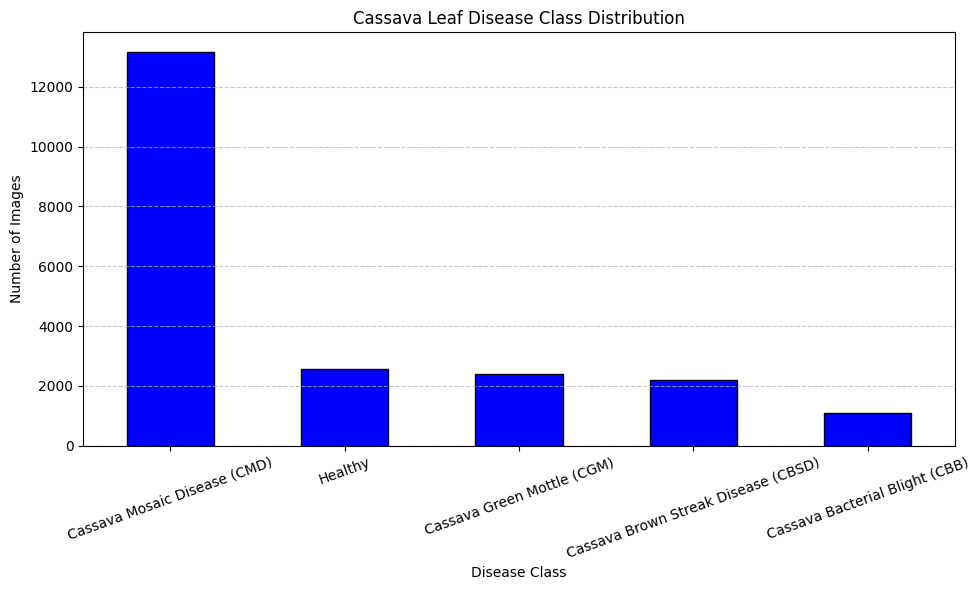

In [10]:

plt.figure(figsize=(10, 6))
df_train['class_name'].value_counts().plot(kind='bar', color='blue', edgecolor='black')

plt.title("Cassava Leaf Disease Class Distribution")
plt.xlabel("Disease Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [11]:
X= df_train["image_id"]
Y= df_train["label"]

*#printing random images*


In [12]:

def random_img(train_dir,X):
    for i in np.random.randint(0, len(X), size=3):
        img_path = os.path.join(train_dir, X[i])
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.axis("off")
        plt.show()
  

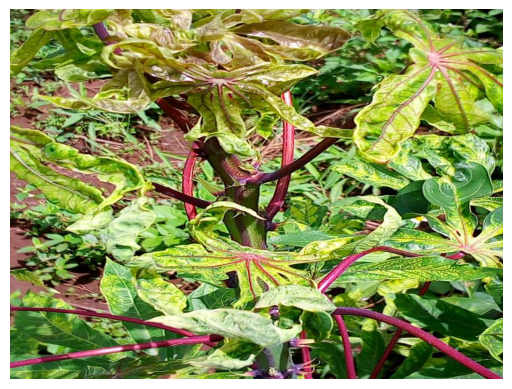

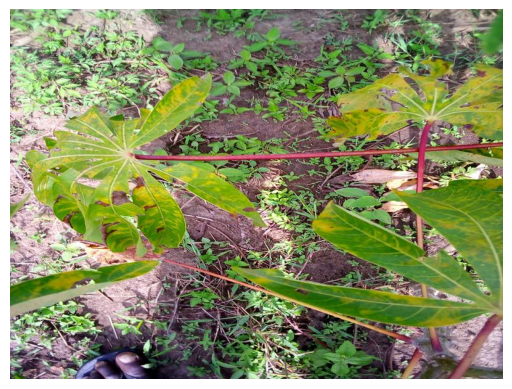

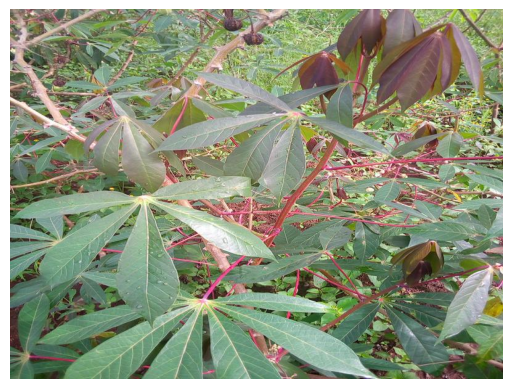

In [13]:
random_img(train_dir,X)

In [14]:
def random_img_with_label(train_dir, X, Y, map_classes):
    import matplotlib.pyplot as plt
    import numpy as np
    import os

    plt.figure(figsize=(15, 9))
    for i, idx in enumerate(np.random.randint(0, len(X), size=15)):
        img_path = os.path.join(train_dir, X[idx])
        img = plt.imread(img_path)

        plt.subplot(3, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")

        # Use label Y[idx] to get class name from map_classes dict
        plt.title(map_classes[Y[idx]], fontsize=9)

    plt.tight_layout()
    plt.show()

*     "0": "Cassava Bacterial Blight (CBB)",
*     "1": "Cassava Brown Streak Disease (CBSD)",
*     "2": "Cassava Green Mottle (CGM)",
*     "3": "Cassava Mosaic Disease (CMD)",
*     "4": "Healthy"


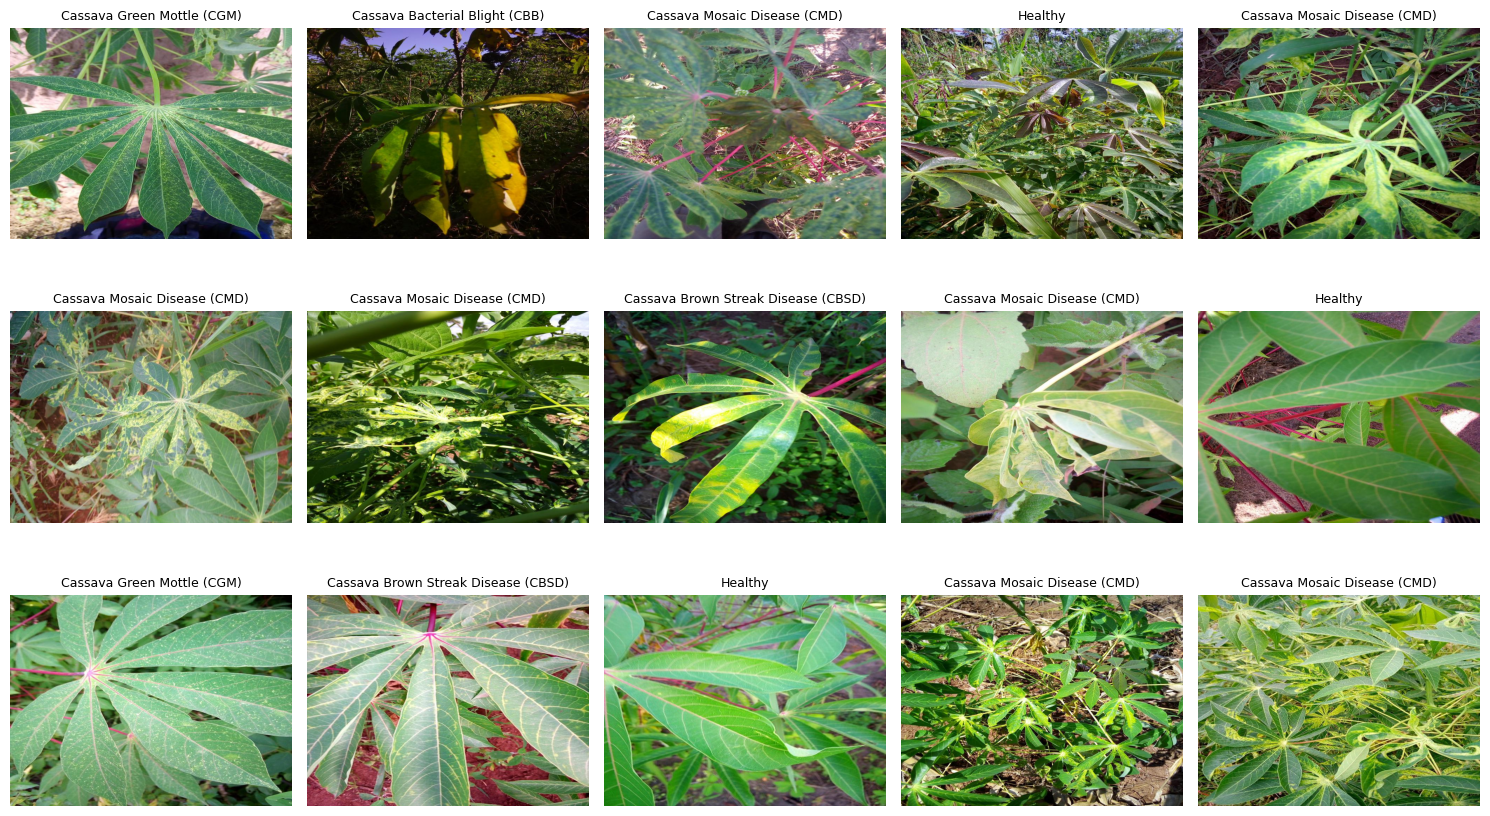

In [15]:

random_img_with_label(train_dir, X, Y, map_classes)

In [16]:
df_train.isnull().sum()

image_id      0
label         0
class_name    0
dtype: int64

# **# Loading training images**

In [17]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and labels
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [18]:
len(X_train),len(X_test),len(Y_train) ,len(Y_test)

(14977, 6420, 14977, 6420)

In [19]:
def process_image(image_id, label):
    image_path = tf.strings.join([
        "/kaggle/input/cassava-leaf-disease-classification/train_images/", image_id
    ])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


In [20]:
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE
def create_batch(X, y=None, batch_size=BATCH_SIZE, validation_data=False, test_data=False):
    """
    Creates TensorFlow data batches for training, validation, or test sets.
    """
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices(tf.constant(X))
        return data.map(process_image).batch(batch_size).cache().prefetch(AUTOTUNE)

    print("Creating validation data batches..." if validation_data else "Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))

    if not validation_data:
        data = data.shuffle(buffer_size=len(X))

    return data.map(process_image).batch(batch_size).cache().prefetch(AUTOTUNE)


In [21]:
import tensorflow as tf
train_data = create_batch(X_train, Y_train)
val_data = create_batch(X_test, Y_test, validation_data=True)

Creating training data batches...
Creating validation data batches...


I0000 00:00:1751784117.070699      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751784117.071344      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [22]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)))

In [23]:
len(train_data),len(val_data)

(1873, 803)

# SAVE DATA

In [24]:
# Save training data
np.savez_compressed("/kaggle/working/train_data.npz", X=X_train, Y=Y_train)

# Save validation data
np.savez_compressed("/kaggle/working/val_data.npz", X=X_test, Y=Y_test)

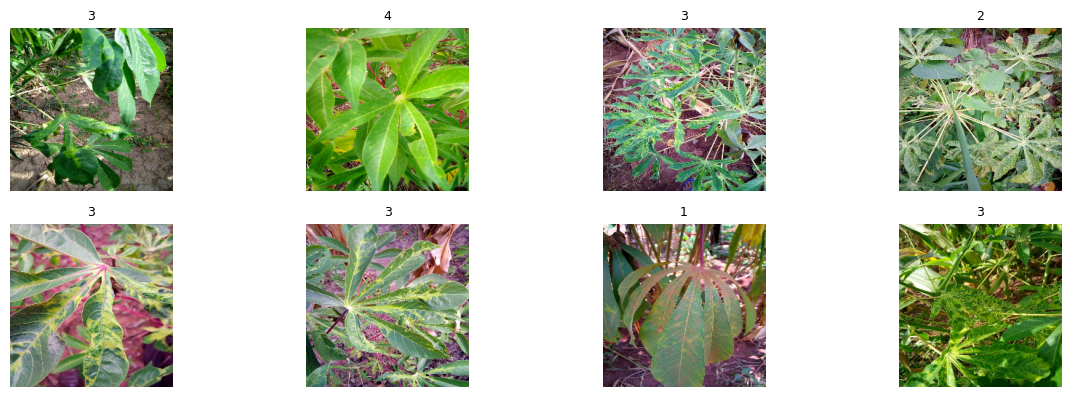

In [25]:
element_spec = (
    tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # batched image shape
    tf.TensorSpec(shape=(None,), dtype=tf.int64)                 # batched labels
)

# Load .npz file
train_npz = np.load('/kaggle/working/train_data.npz',allow_pickle=True)
X_train = train_npz['X']
Y_train = train_npz['Y']



def show_images(images, labels, class_map=None):
    import numpy as np
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 8))
    for i in range(min(len(images), 16)):  # Limit to 16 images
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        label = int(labels[i])
        title = class_map[label] if class_map else str(label)
        plt.title(title, fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


for batch_images, batch_labels in train_data.take(1):
    show_images(batch_images.numpy(), batch_labels.numpy())




# MODEL BUILDING

In [26]:


# Constants
INPUT_SHAPE = (224, 224, 3)
OUTPUT_SHAPE = 5

base_model = EfficientNetB3(include_top=False, weights='imagenet',input_shape= INPUT_SHAPE)


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
base_model.summary()

Model: "efficientnetb3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)             

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 10,696,232 (40.80 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [28]:
from tensorflow.keras import layers,models

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(5,activation='softmax'))



In [51]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,360,276 (127.26 MB)

 Trainable params: 11,090,989 (42.31 MB)

 Non-trainable params: 87,303 (341.03 KB)

 Optimizer params: 22,181,984 (84.62 MB)

In [29]:
train_npz = np.load('/kaggle/working/train_data.npz', allow_pickle=True)
X_train = train_npz['X']
Y_train = train_npz['Y']

val_npz = np.load('/kaggle/working/val_data.npz', allow_pickle=True)
X_val = val_npz['X']
Y_val = val_npz['Y']



# Mixed precision (for GPU speedup)
mixed_precision.set_global_policy('mixed_float16')
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Paths for saving
checkpoint_path = "/kaggle/working/Model_checkpoint.keras"
tensorboard_log_dir = "/kaggle/working/tensorboard_logs/Model"

# Define callbacks


checkpoint = ModelCheckpoint(filepath='./best_model.keras', monitor='val_loss', save_best_only=True,verbose=1)

reducelr = ReduceLROnPlateau( 
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    mode='min',
    verbose=1
)

model_callbacks = [checkpoint,reducelr]

In [30]:
train_data = create_batch(X_train, Y_train)
val_data = create_batch(X_val, Y_val, validation_data=True)
print(len(X_train))
print(len(Y_train))


Creating training data batches...
Creating validation data batches...
14977
14977


In [31]:
import math

train_steps = math.ceil(len(X_train) / BATCH_SIZE)
val_steps = math.ceil(len(X_test) / BATCH_SIZE)
print(train_steps,val_steps)

1873 803


In [32]:
def train_ten_epochs(model, train_data, val_data):

    
    """
    Trains the model for 10 epochs with base model frozen.
    """
    print(" Training with base model frozen...")
    
    # Freeze base model
    model.layers[0].trainable = False

    # Compile
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train
    history = model.fit(
    train_data,
    batch_size = 8,
    epochs = 10,
    steps_per_epoch = train_steps,
    validation_data = val_data,
    validation_steps = val_steps,
    callbacks = model_callbacks)
    

In [33]:
history1 = train_ten_epochs(model, train_data, val_data)

 Training with base model frozen...
Epoch 1/10


I0000 00:00:1751784147.514130      99 service.cc:148] XLA service 0x7fa290019a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751784147.514952      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751784147.514971      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751784150.593120      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


   7/1873 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - accuracy: 0.4946 - loss: 1.3636  

I0000 00:00:1751784167.670548      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1873/1873 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6014 - loss: 1.2692
Epoch 1: val_loss improved from inf to 1.14110, saving model to ./best_model.keras
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 167s 65ms/step - accuracy: 0.6014 - loss: 1.2691 - val_accuracy: 0.6302 - val_loss: 1.1411 - learning_rate: 0.0010
Epoch 2/10
1871/1873 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6065 - loss: 1.2126
Epoch 2: val_loss improved from 1.14110 to 1.13447, saving model to ./best_model.keras
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.6065 - loss: 1.2126 - val_accuracy: 0.6302 - val_loss: 1.1345 - learning_rate: 0.0010
Epoch 3/10
1870/1873 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6065 - loss: 1.2007
Epoch 3: val_loss did not improve from 1.13447
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.6065 - loss: 1.2007 - val_accuracy: 0.6302 - val_loss: 1.1357 - learning_rate: 0.0010
Epoch 4/10
1871/1873 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6065 - loss: 1.1924
Ep

In [34]:
#model.save("best_model.keras") 

In [35]:
model = tf.keras.models.load_model("best_model.keras")

In [41]:
def fine_tune(model, train_data, val_data):
    """
    Fine-tunes the entire model (unfreezes base).
    """
    print(" Fine-tuning the model...")

    # Unfreeze base model
    model.layers[0].trainable = True

    # Recompile with lower LR
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tune
    history = model.fit(train_data,
                        validation_data=val_data,
                        epochs=10,
                       callbacks=[model_callbacks])
    return history

In [42]:
history2 = fine_tune(model, train_data, val_data)

 Fine-tuning the model...
Epoch 1/10
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6341 - loss: 1.0843
Epoch 1: val_loss did not improve from 1.12573
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 328s 92ms/step - accuracy: 0.6342 - loss: 1.0843 - val_accuracy: 0.1168 - val_loss: 2.8391 - learning_rate: 0.0010
Epoch 2/10
1872/1873 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7198 - loss: 0.7789
Epoch 2: val_loss did not improve from 1.12573
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 92s 49ms/step - accuracy: 0.7198 - loss: 0.7789 - val_accuracy: 0.1170 - val_loss: 1.9178 - learning_rate: 0.0010
Epoch 3/10
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7486 - loss: 0.7046
Epoch 3: val_loss did not improve from 1.12573
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 92s 49ms/step - accuracy: 0.7486 - loss: 0.7046 - val_accuracy: 0.1069 - val_loss: 1.9246 - learning_rate: 0.0010
Epoch 4/10
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7725 - loss: 0.6321
Epoch 4: val_loss did not improve from 1.

In [43]:
#model = model.save("best_model1.keras") 

In [41]:
model = tf.keras.models.load_model("best_model.keras")

# PREDICTIONS 

In [60]:
predictions= model.predict(val_data)

803/803 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step


In [61]:

len(predictions)

6420

In [62]:

predictions[0]

array([0.05588, 0.2725 , 0.10516, 0.00639, 0.56   ], dtype=float16)

In [63]:

def get_pred_label(pred_prob):
  '''
  getting name of disease from probabilities of prediction
  '''

  return disease_names[np.argmax(pred_prob)]

In [67]:

get_pred_label(predictions[0]), get_pred_label(predictions[653]),
get_pred_label(predictions[100])

'Cassava Mosaic Disease (CMD)'

In [68]:
def unbatch_data(data):

  images = []
  labels = []

  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(disease_names[np.argmax(label)])
  return images, labels

In [69]:
val_images, val_labels =  unbatch_data(val_data)

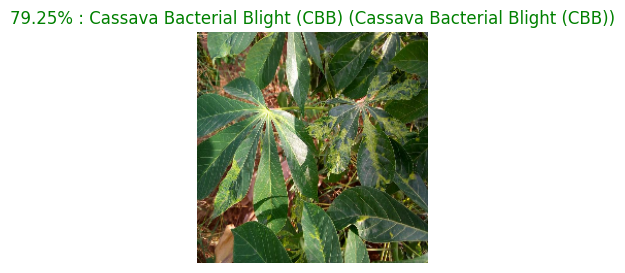

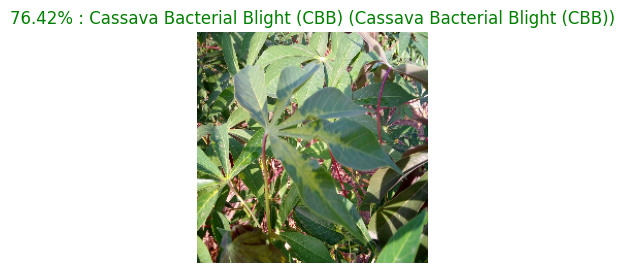

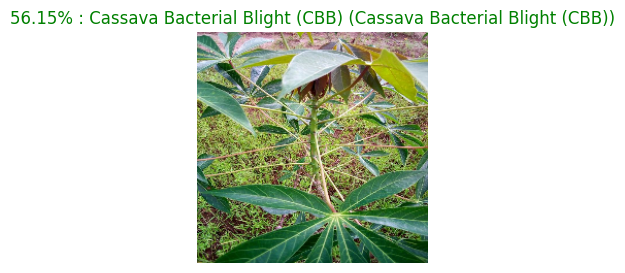

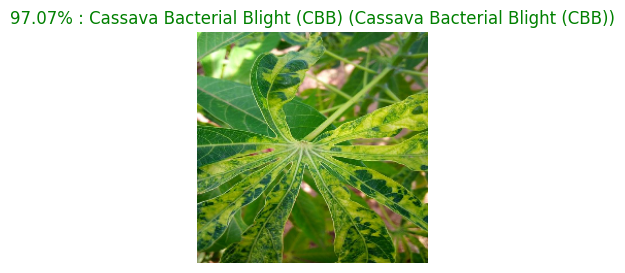

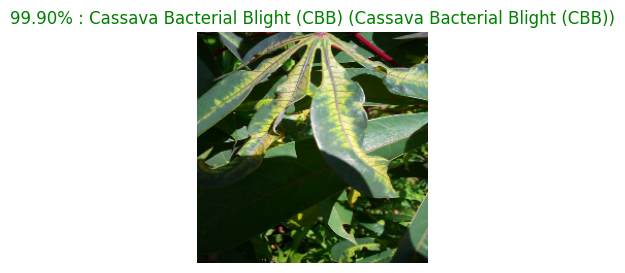

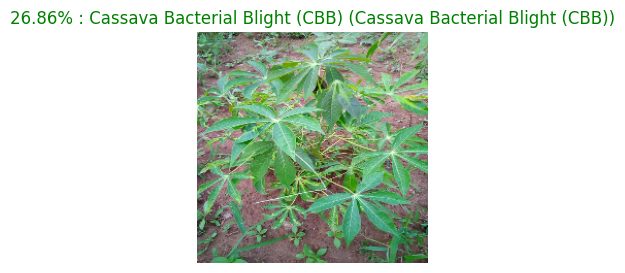

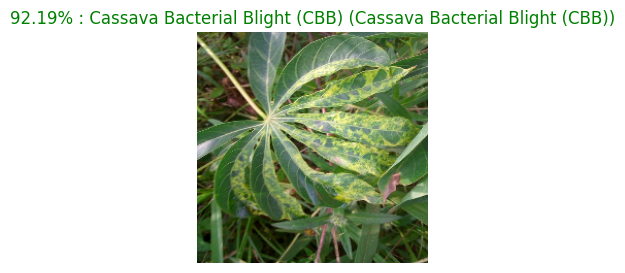

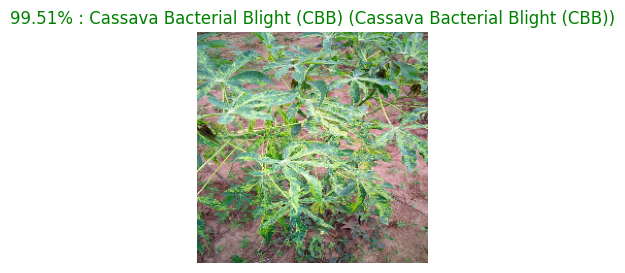

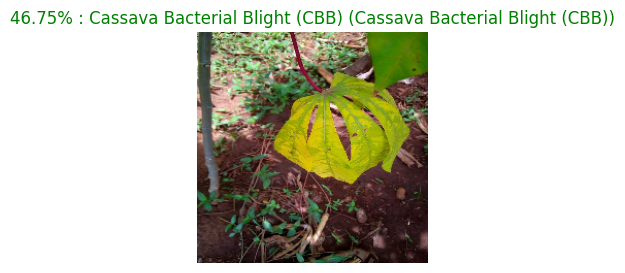

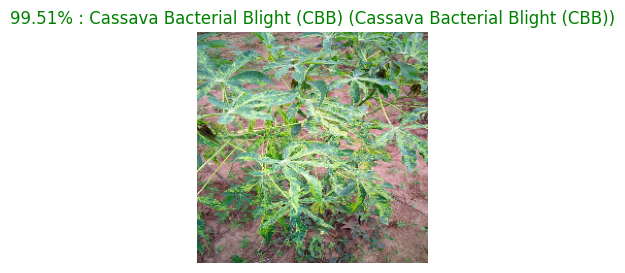

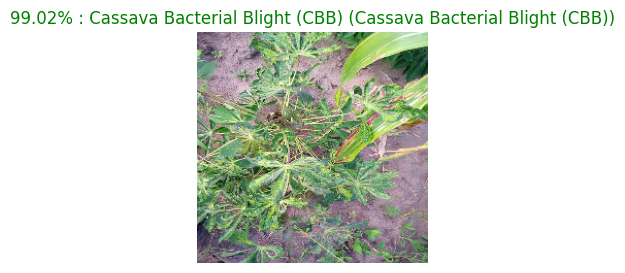

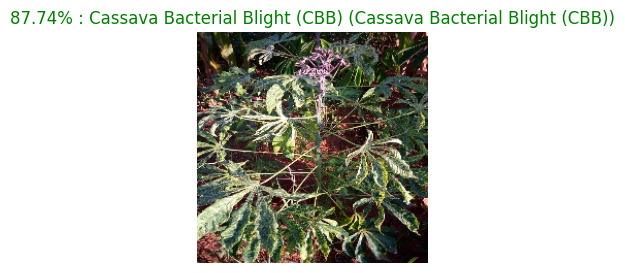

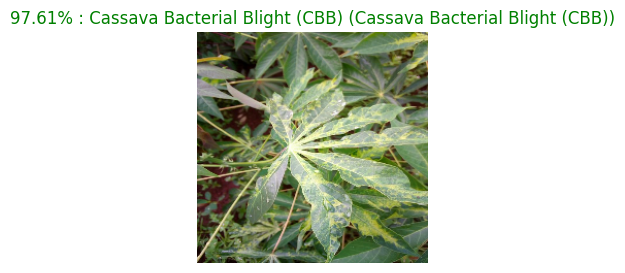

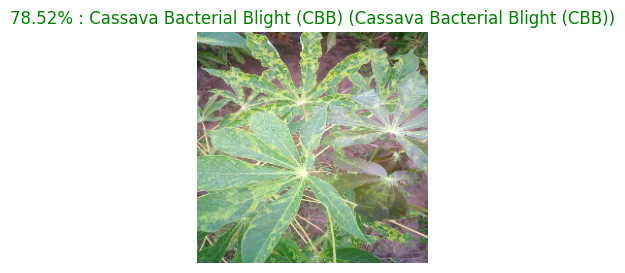

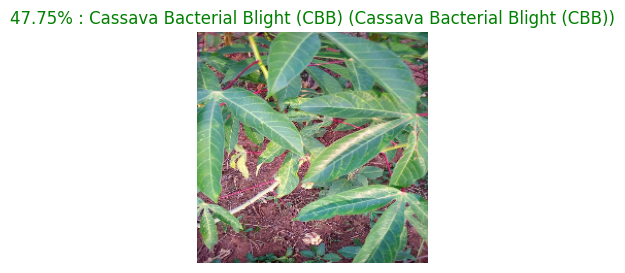

In [70]:
import matplotlib.pyplot as plt
import numpy as np

def plot_prediction(images, labels, prediction_probabilities, n):
    img = images[n]
    true_label = labels[n]
    pred_prob = prediction_probabilities[n]

    pred_label = get_pred_label(np.argmax(pred_prob))
    confidence = np.max(pred_prob) * 100
    color = 'green' if pred_label == true_label else 'red'

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{confidence:.2f}% : {pred_label} ({true_label})", color=color)

# Display predictions for selected indices
indices = [7, 5, 49, 16, 3387, 156, 963, 13, 968, 13, 56, 954, 789, 548, 2989]

for i in indices:
    plt.figure(figsize=(3, 3))
    plot_prediction(val_images, val_labels, predictions, n=i)
    plt.show()
